Image Classification

This worksheet will help you understand image classification and its constraints. The code has
 been successfully tested on Google Colaboratory.

1. Setup: Import required Libraries

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

Step 2: Load the data • Raw data download from the Cats vs Dogs dataset


In [ ]:
!curl -O https://download.microsoft.com/download/3/E/1/3E1C3F21-ECDB-4869-8368-6DEBA77B919F/kagglecatsanddogs_5340.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  786M  100  786M    0     0   154M      0  0:00:05  0:00:05 --:--:--  159M


Step 3: Unzip the data and List

In [ ]:
!unzip -q kagglecatsanddogs_5340.zip
!ls


 CDLA-Permissive-2.0.pdf      PetImages        sample_data
 kagglecatsanddogs_5340.zip  'readme[1].txt'


In [ ]:
!ls PetImages

Cat  Dog


Step 4: Filter out corrupted images

In [ ]:
import os
num_skipped = 0
for folder_name in ("Cat", "Dog"):
  folder_path = os.path.join("PetImages", folder_name)
  for fname in os.listdir(folder_path):
    fpath = os.path.join(folder_path, fname)
    try:
      fobj = open(fpath, "rb")
      is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
    finally:
      fobj.close()

    if not is_jfif:
      num_skipped += 1
      # Delete corrupted image
      os.remove(fpath)
print("Deleted %d images" % num_skipped)


Deleted 1590 images


Step 5: Generate a Dataset

In [ ]:
image_size = (180, 180)
batch_size = 32
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="training",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "PetImages",
    validation_split=0.2,
    subset="validation",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size
)


Found 23410 files belonging to 2 classes.
Using 18728 files for training.
Found 23410 files belonging to 2 classes.
Using 4682 files for validation.


Step 6: Visualise the data

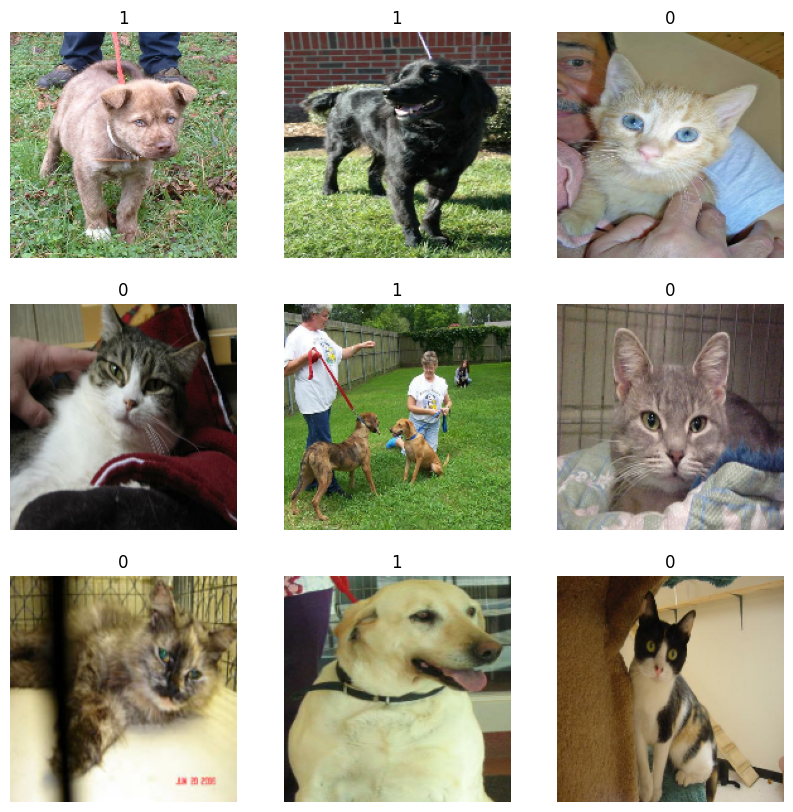

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
      for i in range(9):
       ax = plt.subplot(3, 3, i +1)
       plt.imshow(images[i].numpy().astype("uint8"))
       plt.title(int(labels[i]))
       plt.axis("off")


Step 7 Using image data augmetation

In [ ]:

data_augmentation = keras.Sequential(
    [
      layers.RandomFlip("horizontal"),
      layers.RandomRotation(0.1),
     ]
)


Step 8: Augmented Sample visualisation

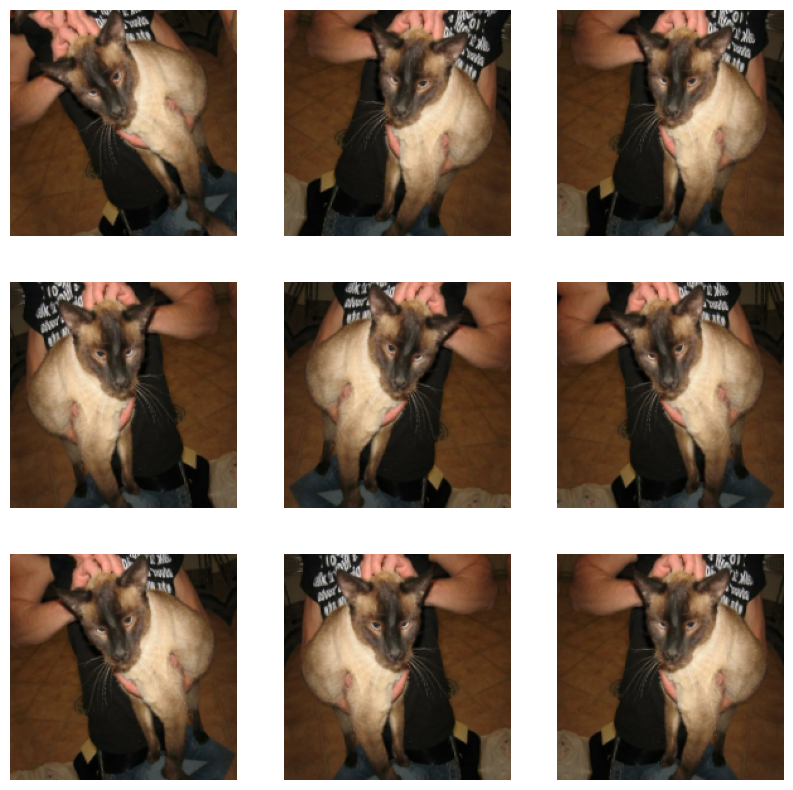

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

Step 9: Standardising while preprocessing the data

In [ ]:
augmented_train_ds=train_ds.map(lambda x, y: (data_augmentation(x,training=True), y))


Step 10: Configure the dataset for performance

In [ ]:
train_ds =train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

Step 11: Build a model

In [ ]:
def make_model(input_shape,num_classes):
   inputs=keras.Input(shape=input_shape)
   #Image augmentation block
   x=data_augmentation(inputs)

   #Entryblock
   x=layers.Rescaling(1.0/255)(x)
   x=layers.Conv2D(32,3,strides=2,padding="same")(x)
   x=layers.BatchNormalization()(x)
   x=layers.Activation("relu")(x)

   x=layers.Conv2D(64,3,padding="same")(x)
   x=layers.BatchNormalization()(x)
   x=layers.Activation("relu")(x)

   previous_block_activation= x #Setasideresidual

   for size in[128,256,512, 728]:
     x=layers.Activation("relu")(x)
     x=layers.SeparableConv2D(size,3,padding="same")(x)
     x=layers.BatchNormalization()(x)


     x=layers.Activation("relu")(x)
     x=layers.SeparableConv2D(size,3,padding="same")(x)
     x=layers.BatchNormalization()(x)

     x=layers.MaxPooling2D(3,strides=2,padding="same")(x)

     #Project residual
     residual=layers.Conv2D(size,1,strides=2,padding="same")(
        previous_block_activation
     )
     x=layers.add([x,residual])#Add back residual
     previous_block_activation =x#Set aside next residual

   x =  layers.SeparableConv2D(1024,3,padding="same")(x)
   x = layers.BatchNormalization()(x)
   x = layers.Activation("relu")(x)

   x = layers.GlobalAveragePooling2D()(x)
   if num_classes == 2:
    activation="sigmoid"
    units = 1
   else:
    activation="softmax"
    units = num_classes
   x=layers.Dropout(0.5)(x)
   outputs=layers.Dense(units, activation=activation)(x)
   return keras.Model(inputs,outputs)

model=make_model(input_shape=image_size+(3,),num_classes=2)
keras.utils.plot_model(model,show_shapes=True)


Step 12: Train the model

In [ ]:
epochs = 5
callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]
model.compile(
     optimizer=keras.optimizers.Adam(1e-3),
     loss="binary_crossentropy",
     metrics=["accuracy"],
)

model.fit(
    train_ds,epochs=epochs,callbacks=callbacks,validation_data=val_ds,
)

Epoch 1/5
586/586 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.6336 - loss: 0.6637

586/586 ━━━━━━━━━━━━━━━━━━━━ 4131s 7s/step - accuracy: 0.6337 - loss: 0.6636 - val_accuracy: 0.6452 - val_loss: 0.7339
Epoch 2/5
586/586 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.7867 - loss: 0.4578

586/586 ━━━━━━━━━━━━━━━━━━━━ 4265s 7s/step - accuracy: 0.7867 - loss: 0.4577 - val_accuracy: 0.7221 - val_loss: 0.8182
Epoch 3/5
586/586 ━━━━━━━━━━━━━━━━━━━━ 0s 7s/step - accuracy: 0.8461 - loss: 0.3585

586/586 ━━━━━━━━━━━━━━━━━━━━ 4254s 7s/step - accuracy: 0.8461 - loss: 0.3584 - val_accuracy: 0.7881 - val_loss: 0.4699
Epoch 4/5
252/586 ━━━━━━━━━━━━━━━━━━━━ 38:30 7s/step - accuracy: 0.8708 - loss: 0.3073

Step 13: Run inference on new data

In [ ]:
img=keras.preprocessing.image.load_img("PetImages/Cat/6779.jpg",target_size=image_size)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create batch axis
predictions = model.predict(img_array)
score = predictions[0]
print(
 "This image is %.2f percent cat and %.2f percent dog."
 % (100 * (1- score), 100 * score)
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 747ms/step
This image is 71.17 percent cat and 28.83 percent dog.


/tmp/ipython-input-3739684219.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  "This image is %.2f percent cat and %.2f percent dog."
